# Short-Term Load Forecasting Using Machine Learning

## Project Overview
This notebook implements a comprehensive **Short-Term Load Forecasting (STLF)** system using traditional Machine Learning algorithms. The project predicts electricity demand based on meteorological variables.

### Workflow:
1. **Data Loading & Exploration**
2. **Data Preprocessing** (Missing values, Outliers, Feature Engineering)
3. **Exploratory Data Analysis (EDA)**
4. **Feature Scaling & Train-Test Split**
5. **Machine Learning Models**
   - Linear Regression (Baseline)
   - Ridge Regression (L2 Regularization)
   - Random Forest Regressor
   - Gradient Boosting Regressor
   - XGBoost Regressor
   - Support Vector Regression (SVR)
6. **Hyperparameter Tuning**
7. **Comparative Analysis & Evaluation**

---

## Mathematical Foundation

### Load Forecasting Problem
The objective is to predict electricity load $MW_t$ at time $t$ using:

$$MW_t = f(T_t, GSR_t, RH_t, t) + \epsilon$$

Where:
- $T_t$ = Air Temperature at time $t$
- $GSR_t$ = Global Solar Radiation at time $t$  
- $RH_t$ = Relative Humidity at time $t$
- $\epsilon$ = Random error term

### Evaluation Metrics

| Metric | Formula | Description |
|--------|---------|-------------|
| **MAE** | $\frac{1}{n}\sum_{i=1}^{n}\|y_i - \hat{y}_i\|$ | Mean Absolute Error |
| **RMSE** | $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2}$ | Root Mean Square Error |
| **MAPE** | $\frac{100}{n}\sum_{i=1}^{n}\|\frac{y_i - \hat{y}_i}{y_i}\|$ | Mean Absolute Percentage Error |
| **R²** | $1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$ | Coefficient of Determination |
| **Accuracy** | Percentage of predictions within 10% tolerance | Practical accuracy measure |

## 1. Import Libraries and Configuration
Import all necessary libraries for data manipulation, visualization, and machine learning.

In [35]:
# LIBRARY IMPORTS

# Data Manipulation and Numerical Operations
import pandas as pd              # DataFrame operations
import numpy as np               # Numerical computations
import os

# Visualization Libraries
import matplotlib.pyplot as plt  # Static plots
import seaborn as sns            # Statistical visualizations

# Scikit-learn: Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# XGBoost
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)

# Configure plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")



## 2. Data Loading and Initial Exploration
Load the dataset and perform initial exploration to understand its structure, data types, and basic statistics.

In [36]:
# DATA LOADING

# Load the dataset from CSV file
# The dataset contains hourly electricity load and meteorological variables

# Load the dataset from local storage
df = pd.read_csv('dataset.csv')

# Display basic information about the dataset

print("DATASET OVERVIEW")
print(f"\nDataset Shape: {df.shape[0]} rows x {df.shape[1]} columns")
print(f"\nColumn Names: {list(df.columns)}")

# Display first few rows
print("FIRST 10 ROWS OF DATA")
df.head(10)

DATASET OVERVIEW

Dataset Shape: 24528 rows x 5 columns

Column Names: ['Time', 'MW', 'Air Temperature', 'Global Solar Radiation', 'Relative Humidity']
FIRST 10 ROWS OF DATA


,Time,MW,Air Temperature,Global Solar Radiation,Relative Humidity
0,2022-10-19 01:00,0.8,14.50,0.0,88.8
1,2022-10-19 02:00,0.8,14.40,0.0,87.9
2,2022-10-19 03:00,0.8,14.00,0.0,92.3
3,2022-10-19 04:00,0.8,13.20,0.0,95.8
4,2022-10-19 05:00,0.8,12.65,0.0,97.9
5,2022-10-19 06:00,1.2,12.10,0.0,100.0
6,2022-10-19 07:00,2.0,12.00,18.6,100.0
7,2022-10-19 08:00,2.3,14.30,171.3,92.9
8,2022-10-19 09:00,2.1,17.20,393.6,77.0
9,2022-10-19 10:00,2.0,18.40,489.6,70.4


In [37]:
# DATA TYPES AND STATISTICAL SUMMARY

# Check data types and identify any type conversion needs

print("DATA TYPES")
print(df.dtypes)

print("\n STATISTICAL SUMMARY")
df.describe().round(2)

DATA TYPES
Time                       object
MW                        float64
Air Temperature           float64
Global Solar Radiation    float64
Relative Humidity         float64
dtype: object

 STATISTICAL SUMMARY


,MW,Air Temperature,Global Solar Radiation,Relative Humidity
count,24408.00,24528.00,24528.00,24528.00
mean,2.51,18.62,186.33,78.98
std,5.03,6.53,265.87,23.78
min,0.00,1.10,0.00,5.90
25%,1.60,13.90,0.00,60.60
50%,2.30,20.10,7.50,89.60
75%,3.10,23.20,346.55,100.00
max,404.00,32.90,1105.60,100.00


MISSING VALUES ANALYSIS
                Column  Missing Count  Missing Percentage
                  Time              0                0.00
                    MW            120                0.49
       Air Temperature              0                0.00
Global Solar Radiation              0                0.00
     Relative Humidity              0                0.00


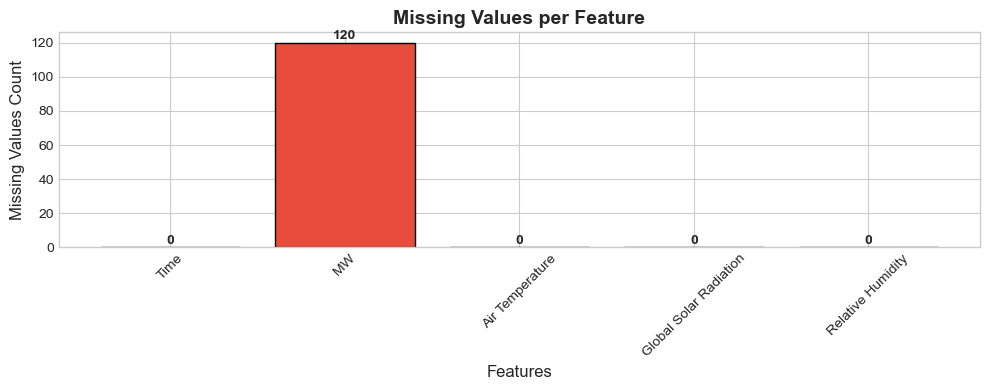


Total missing values: 120


In [38]:
# MISSING VALUES ANALYSIS

# Check for missing values in each column
print("MISSING VALUES ANALYSIS")


missing_data = pd.DataFrame({
    'Column': df.columns,
    'Missing Count': df.isnull().sum().values,
    'Missing Percentage': (df.isnull().sum().values / len(df) * 100).round(2)
})
print(missing_data.to_string(index=False))

# Visual representation of missing values
fig, ax = plt.subplots(figsize=(10, 4))
colors = ['#2ecc71' if x == 0 else '#e74c3c' for x in df.isnull().sum().values]
bars = ax.bar(df.columns, df.isnull().sum().values, color=colors, edgecolor='black')
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Missing Values Count', fontsize=12)
ax.set_title('Missing Values per Feature', fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45)

# Add value labels on bars
for bar, val in zip(bars, df.isnull().sum().values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            str(val), ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal missing values: {df.isnull().sum().sum()}")

## 3. Data Preprocessing
This section covers:
- **DateTime Conversion** and temporal feature extraction
- **Missing Value Imputation** using forward/backward fill
- **Outlier Detection** using IQR method
- **Outlier Treatment** using capping

### Temporal Feature Engineering
Cyclical features are created using sine/cosine transformation to preserve the cyclical nature of time:
$$Hour_{sin} = \sin\left(\frac{2\pi \times Hour}{24}\right)$$
$$Hour_{cos} = \cos\left(\frac{2\pi \times Hour}{24}\right)$$

In [39]:
# DATETIME CONVERSION AND FEATURE ENGINEERING

# Convert 'Time' column to datetime format
# Handle special case: "24:00" format (represents midnight of next day)

# Create a copy of the dataframe for preprocessing
df_processed = df.copy()

# Handle "24:00" time format by converting to "00:00" of next day
def convert_time(time_str):
    """Convert time string, handling 24:00 as 00:00 of next day"""
    if '24:00' in str(time_str):
        date_part = time_str.split(' ')[0]
        new_time = pd.to_datetime(date_part) + pd.Timedelta(days=1)
        return new_time
    return pd.to_datetime(time_str)

df_processed['Time'] = df_processed['Time'].apply(convert_time)

# Extract temporal features
# These features capture cyclical patterns in electricity consumption
df_processed['Hour'] = df_processed['Time'].dt.hour           # Hour of day (0-23)
df_processed['Day'] = df_processed['Time'].dt.day             # Day of month (1-31)
df_processed['Month'] = df_processed['Time'].dt.month         # Month (1-12)
df_processed['DayOfWeek'] = df_processed['Time'].dt.dayofweek # Day of week (0=Mon, 6=Sun)
df_processed['WeekOfYear'] = df_processed['Time'].dt.isocalendar().week.astype(int)
df_processed['IsWeekend'] = (df_processed['DayOfWeek'] >= 5).astype(int)

# Create cyclical features using sine/cosine transformation
# This preserves the cyclical nature of time (e.g., hour 23 is close to hour 0)
df_processed['Hour_sin'] = np.sin(2 * np.pi * df_processed['Hour'] / 24)
df_processed['Hour_cos'] = np.cos(2 * np.pi * df_processed['Hour'] / 24)
df_processed['Month_sin'] = np.sin(2 * np.pi * df_processed['Month'] / 12)
df_processed['Month_cos'] = np.cos(2 * np.pi * df_processed['Month'] / 12)
df_processed['DayOfWeek_sin'] = np.sin(2 * np.pi * df_processed['DayOfWeek'] / 7)
df_processed['DayOfWeek_cos'] = np.cos(2 * np.pi * df_processed['DayOfWeek'] / 7)


print("TEMPORAL FEATURES EXTRACTED")
print(f"\nDate Range: {df_processed['Time'].min()} to {df_processed['Time'].max()}")
print(f"Total Days: {(df_processed['Time'].max() - df_processed['Time'].min()).days}")
print(f"\nNew Features Added:")
print("  - Hour, Day, Month, DayOfWeek, WeekOfYear, IsWeekend")
print("  - Cyclical encodings: Hour_sin/cos, Month_sin/cos, DayOfWeek_sin/cos")

df_processed.head()

TEMPORAL FEATURES EXTRACTED

Date Range: 2022-10-19 01:00:00 to 2025-10-18 00:00:00
Total Days: 1094

New Features Added:
  - Hour, Day, Month, DayOfWeek, WeekOfYear, IsWeekend
  - Cyclical encodings: Hour_sin/cos, Month_sin/cos, DayOfWeek_sin/cos


,Time,MW,Air Temperature,Global Solar Radiation,Relative Humidity,Hour,Day,Month,DayOfWeek,WeekOfYear,IsWeekend,Hour_sin,Hour_cos,Month_sin,Month_cos,DayOfWeek_sin,DayOfWeek_cos
0,2022-10-19 01:00:00,0.8,14.50,0.0,88.8,1,19,10,2,42,0,0.258819,0.965926,-0.866025,0.5,0.974928,-0.222521
1,2022-10-19 02:00:00,0.8,14.40,0.0,87.9,2,19,10,2,42,0,0.500000,0.866025,-0.866025,0.5,0.974928,-0.222521
2,2022-10-19 03:00:00,0.8,14.00,0.0,92.3,3,19,10,2,42,0,0.707107,0.707107,-0.866025,0.5,0.974928,-0.222521
3,2022-10-19 04:00:00,0.8,13.20,0.0,95.8,4,19,10,2,42,0,0.866025,0.500000,-0.866025,0.5,0.974928,-0.222521
4,2022-10-19 05:00:00,0.8,12.65,0.0,97.9,5,19,10,2,42,0,0.965926,0.258819,-0.866025,0.5,0.974928,-0.222521


In [40]:
# HANDLING MISSING VALUES

# Strategy: Use forward fill followed by backward fill for time series data
# This preserves temporal continuity in the load data


print("HANDLING MISSING VALUES IN 'MW' COLUMN")
print(f"\nMissing values before imputation: {df_processed['MW'].isnull().sum()}")

# Method: Forward fill then backward fill (preserves temporal patterns)
df_processed['MW'] = df_processed['MW'].fillna(method='ffill').fillna(method='bfill')

print(f"Missing values after imputation: {df_processed['MW'].isnull().sum()}")
print("\nImputation method: Forward Fill + Backward Fill")
print("  This method preserves temporal continuity in time series data.")

HANDLING MISSING VALUES IN 'MW' COLUMN

Missing values before imputation: 120
Missing values after imputation: 0

Imputation method: Forward Fill + Backward Fill
  This method preserves temporal continuity in time series data.


OUTLIER DETECTION (IQR Method)

MW Column Statistics:
  Q1 (25th percentile): 1.60
  Q3 (75th percentile): 3.10
  IQR: 1.50
  Lower Bound: -0.65
  Upper Bound: 5.35

Number of outliers detected: 59 (0.24%)


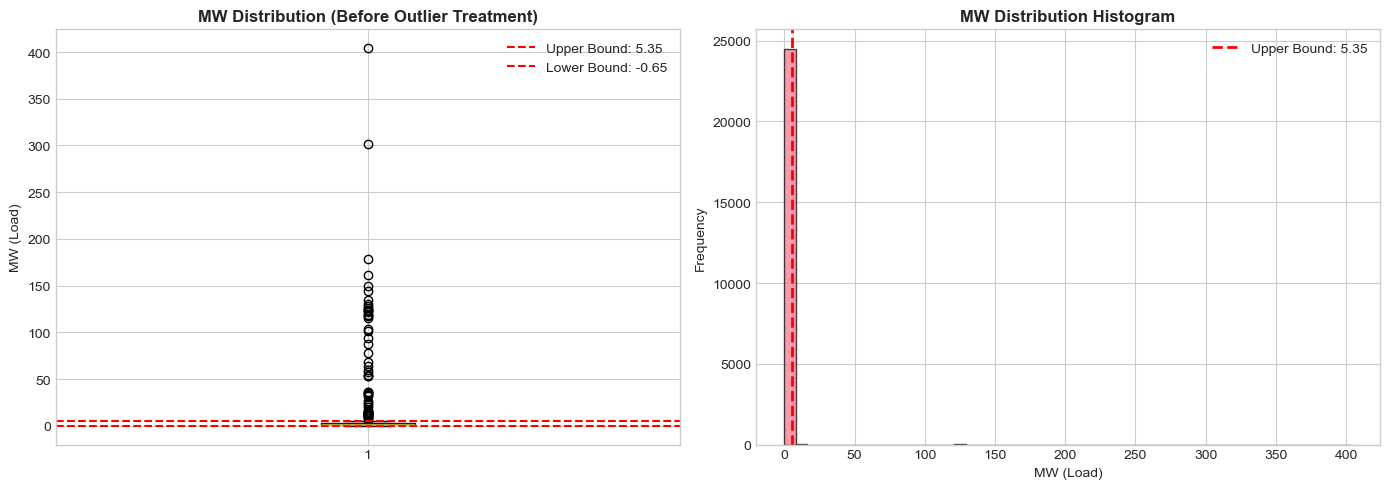

In [41]:
# OUTLIER DETECTION AND TREATMENT

# Using IQR (Interquartile Range) method to detect outliers
# Formula: Outliers are values < Q1 - 1.5*IQR or > Q3 + 1.5*IQR

def detect_outliers_iqr(data, column):
    """
    Detect outliers using IQR method
    IQR = Q3 - Q1
    Lower Bound = Q1 - 1.5 * IQR
    Upper Bound = Q3 + 1.5 * IQR
    """
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound, Q1, Q3, IQR

# Detect outliers in MW column
outliers, lower, upper, Q1, Q3, IQR = detect_outliers_iqr(df_processed, 'MW')


print("OUTLIER DETECTION (IQR Method)")
print(f"\nMW Column Statistics:")
print(f"  Q1 (25th percentile): {Q1:.2f}")
print(f"  Q3 (75th percentile): {Q3:.2f}")
print(f"  IQR: {IQR:.2f}")
print(f"  Lower Bound: {lower:.2f}")
print(f"  Upper Bound: {upper:.2f}")
print(f"\nNumber of outliers detected: {len(outliers)} ({len(outliers)/len(df_processed)*100:.2f}%)")

# Visualize outliers with box plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot before treatment
axes[0].boxplot(df_processed['MW'].dropna(), vert=True)
axes[0].set_title('MW Distribution (Before Outlier Treatment)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('MW (Load)')
axes[0].axhline(y=upper, color='r', linestyle='--', label=f'Upper Bound: {upper:.2f}')
axes[0].axhline(y=lower, color='r', linestyle='--', label=f'Lower Bound: {lower:.2f}')
axes[0].legend()

# Distribution histogram
axes[1].hist(df_processed['MW'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=upper, color='r', linestyle='--', linewidth=2, label=f'Upper Bound: {upper:.2f}')
axes[1].set_title('MW Distribution Histogram', fontsize=12, fontweight='bold')
axes[1].set_xlabel('MW (Load)')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

In [42]:
# OUTLIER TREATMENT - CAPPING METHOD

# Cap outliers at the bounds instead of removing them
# This preserves data points while reducing extreme values impact


print("OUTLIER TREATMENT (Capping Method)")


# Store original statistics
original_max = df_processed['MW'].max()
original_min = df_processed['MW'].min()

# Cap outliers at upper and lower bounds
df_processed['MW'] = df_processed['MW'].clip(lower=max(0, lower), upper=upper)

print(f"\nBefore Treatment:")
print(f"  Min MW: {original_min:.2f}, Max MW: {original_max:.2f}")
print(f"\nAfter Treatment (Capping at bounds):")
print(f"  Min MW: {df_processed['MW'].min():.2f}, Max MW: {df_processed['MW'].max():.2f}")
print(f"\nOutliers capped successfully!")
print(f"  Lower bound used: {max(0, lower):.2f}")
print(f"  Upper bound used: {upper:.2f}")

OUTLIER TREATMENT (Capping Method)

Before Treatment:
  Min MW: 0.00, Max MW: 404.00

After Treatment (Capping at bounds):
  Min MW: 0.00, Max MW: 5.35

Outliers capped successfully!
  Lower bound used: 0.00
  Upper bound used: 5.35


## 4. Exploratory Data Analysis (EDA)
Comprehensive visual analysis of the dataset to understand patterns, correlations, and trends.

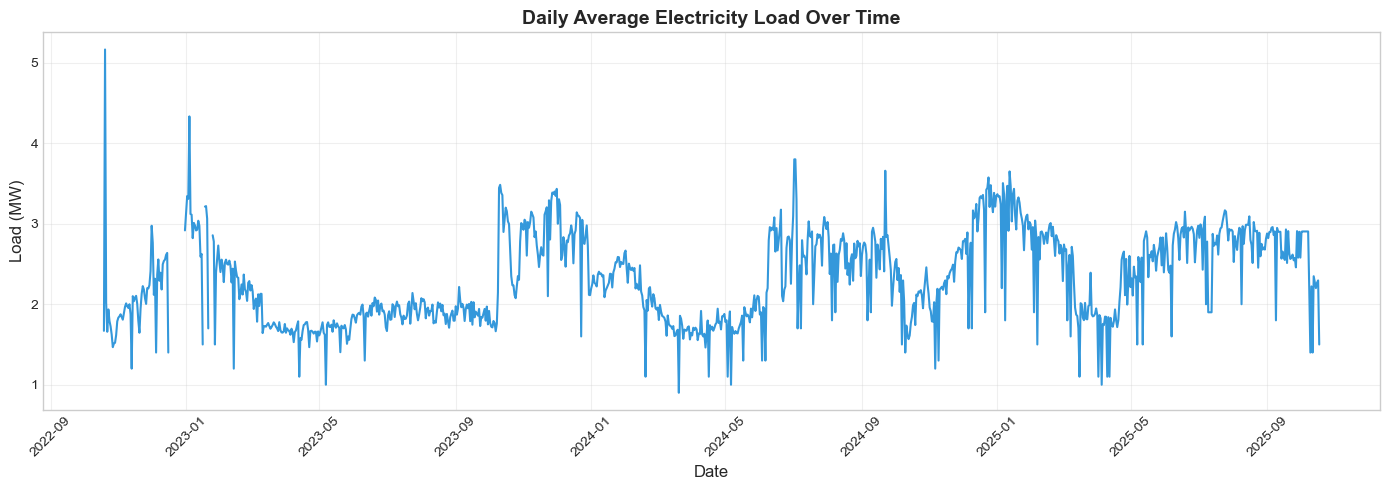

In [43]:
# TIME SERIES VISUALIZATION - Load Pattern Over Time


# Resample data to daily averages for cleaner visualization
df_daily = df_processed.set_index('Time').resample('D').mean().reset_index()

fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(df_daily['Time'], df_daily['MW'], color='#3498db', linewidth=1.5)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Load (MW)', fontsize=12)
ax.set_title('Daily Average Electricity Load Over Time', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# print("This visualization shows the daily average electricity load pattern over the entire dataset period.")

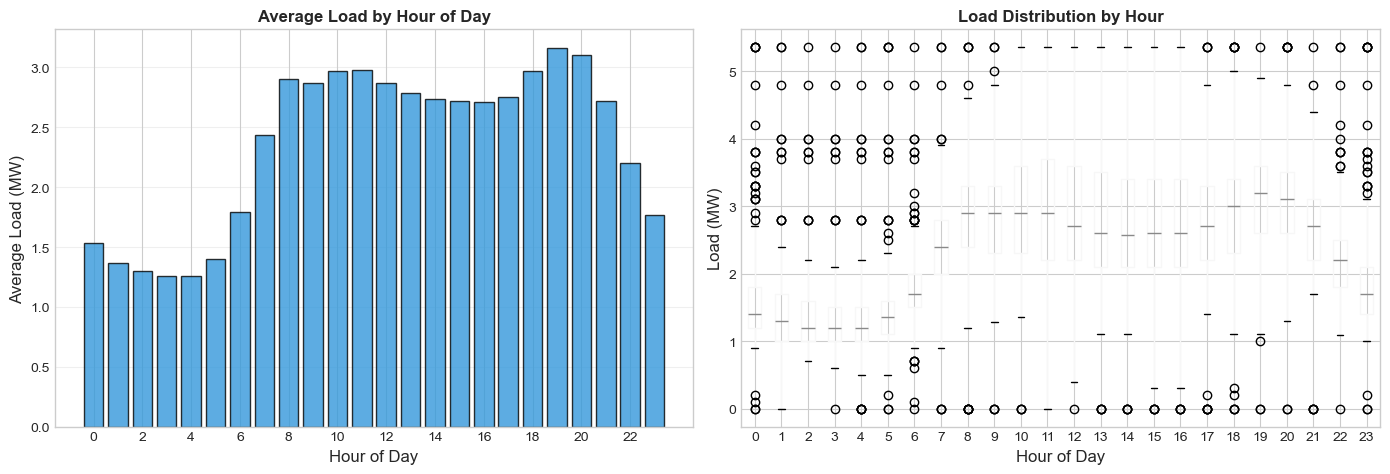

Key Observations:
  Peak load hour: 19:00 (3.16 MW)
  Minimum load hour: 3:00 (1.26 MW)


In [44]:
# HOURLY LOAD PATTERN ANALYSIS


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Average load by hour
hourly_load = df_processed.groupby('Hour')['MW'].mean()
axes[0].bar(hourly_load.index, hourly_load.values, color='#3498db', edgecolor='black', alpha=0.8)
axes[0].set_xlabel('Hour of Day', fontsize=12)
axes[0].set_ylabel('Average Load (MW)', fontsize=12)
axes[0].set_title('Average Load by Hour of Day', fontsize=12, fontweight='bold')
axes[0].set_xticks(range(0, 24, 2))
axes[0].grid(axis='y', alpha=0.3)

# Load distribution by hour (box plot)
df_processed.boxplot(column='MW', by='Hour', ax=axes[1])
axes[1].set_xlabel('Hour of Day', fontsize=12)
axes[1].set_ylabel('Load (MW)', fontsize=12)
axes[1].set_title('Load Distribution by Hour', fontsize=12, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.show()

print("Key Observations:")
print(f"  Peak load hour: {hourly_load.idxmax()}:00 ({hourly_load.max():.2f} MW)")
print(f"  Minimum load hour: {hourly_load.idxmin()}:00 ({hourly_load.min():.2f} MW)")

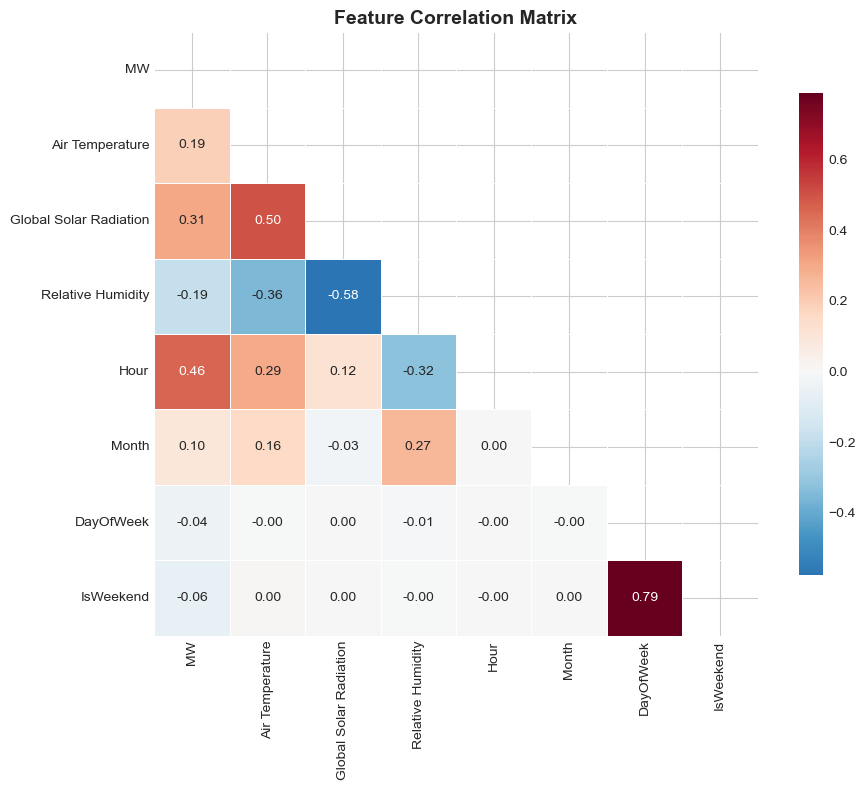

CORRELATIONS WITH TARGET VARIABLE (MW)
  Hour                          : +0.457 (Moderate Positive)
  Global Solar Radiation        : +0.307 (Moderate Positive)
  Air Temperature               : +0.190 (Weak Positive)
  Relative Humidity             : -0.185 (Weak Negative)
  Month                         : +0.096 (Weak Positive)
  IsWeekend                     : -0.064 (Weak Negative)
  DayOfWeek                     : -0.041 (Weak Negative)


In [45]:
# CORRELATION ANALYSIS

# Select numerical columns for correlation
numerical_cols = ['MW', 'Air Temperature', 'Global Solar Radiation', 'Relative Humidity',
                  'Hour', 'Month', 'DayOfWeek', 'IsWeekend']
correlation_matrix = df_processed[numerical_cols].corr()

# Create correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, square=True, linewidths=0.5,
            cbar_kws={'shrink': 0.8})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Display correlations with target variable

print("CORRELATIONS WITH TARGET VARIABLE (MW)")
target_correlations = correlation_matrix['MW'].drop('MW').sort_values(key=abs, ascending=False)
for feature, corr in target_correlations.items():
    strength = 'Strong' if abs(corr) > 0.5 else 'Moderate' if abs(corr) > 0.3 else 'Weak'
    direction = 'Positive' if corr > 0 else 'Negative'
    print(f"  {feature:30s}: {corr:+.3f} ({strength} {direction})")

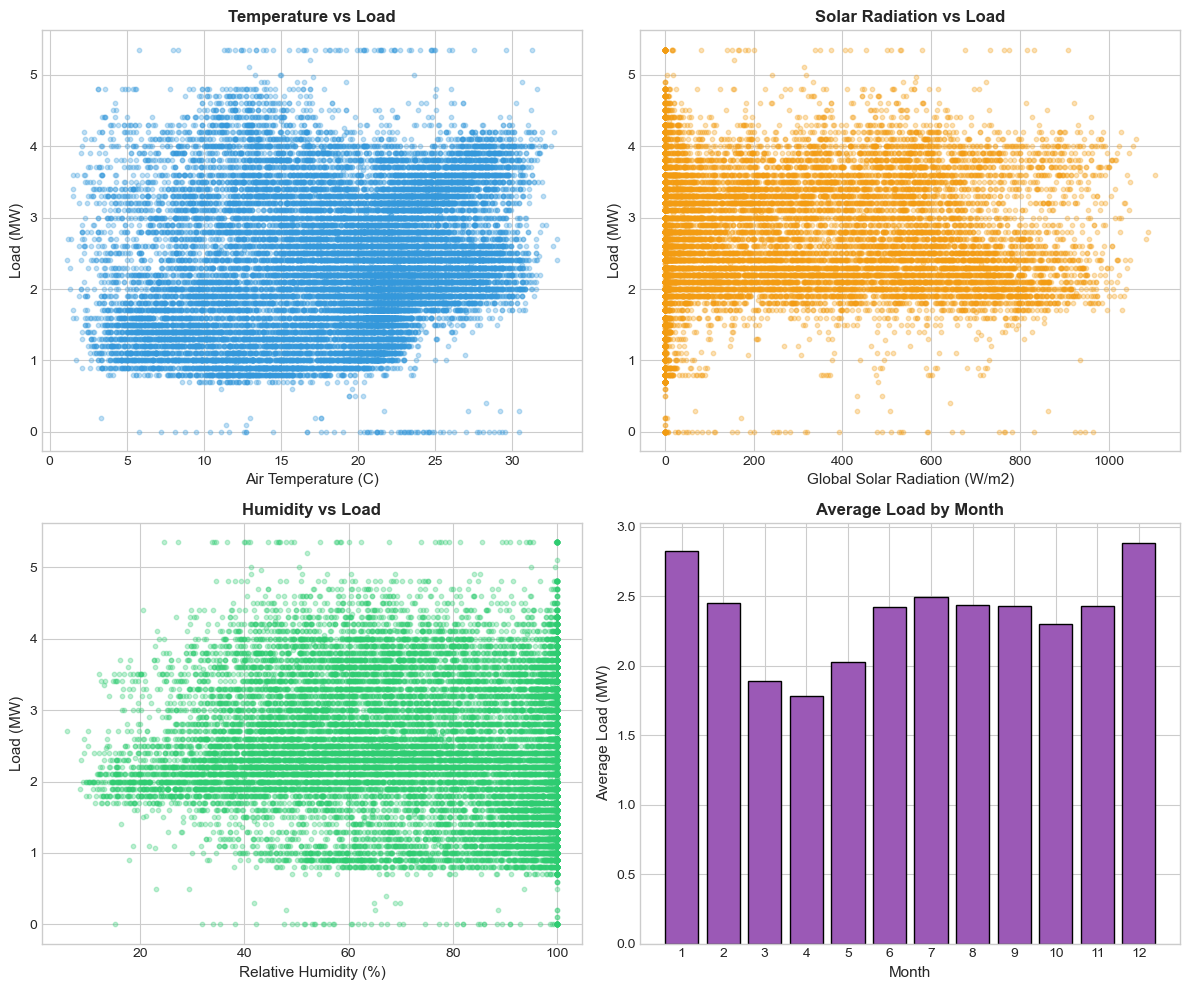

Feature Analysis Summary:
  - Load increases with temperature (positive correlation)
  - Load shows moderate positive correlation with solar radiation
  - Load slightly decreases with higher humidity


In [46]:
# FEATURE RELATIONSHIPS WITH TARGET - SCATTER PLOTS

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Temperature vs MW
axes[0, 0].scatter(df_processed['Air Temperature'], df_processed['MW'],
                   alpha=0.3, s=10, c='#3498db')
axes[0, 0].set_xlabel('Air Temperature (C)', fontsize=11)
axes[0, 0].set_ylabel('Load (MW)', fontsize=11)
axes[0, 0].set_title('Temperature vs Load', fontsize=12, fontweight='bold')

# Solar Radiation vs MW
axes[0, 1].scatter(df_processed['Global Solar Radiation'], df_processed['MW'],
                   alpha=0.3, s=10, c='#f39c12')
axes[0, 1].set_xlabel('Global Solar Radiation (W/m2)', fontsize=11)
axes[0, 1].set_ylabel('Load (MW)', fontsize=11)
axes[0, 1].set_title('Solar Radiation vs Load', fontsize=12, fontweight='bold')

# Humidity vs MW
axes[1, 0].scatter(df_processed['Relative Humidity'], df_processed['MW'],
                   alpha=0.3, s=10, c='#2ecc71')
axes[1, 0].set_xlabel('Relative Humidity (%)', fontsize=11)
axes[1, 0].set_ylabel('Load (MW)', fontsize=11)
axes[1, 0].set_title('Humidity vs Load', fontsize=12, fontweight='bold')

# Monthly pattern
monthly_avg = df_processed.groupby('Month')['MW'].mean()
axes[1, 1].bar(monthly_avg.index, monthly_avg.values, color='#9b59b6', edgecolor='black')
axes[1, 1].set_xlabel('Month', fontsize=11)
axes[1, 1].set_ylabel('Average Load (MW)', fontsize=11)
axes[1, 1].set_title('Average Load by Month', fontsize=12, fontweight='bold')
axes[1, 1].set_xticks(range(1, 13))

plt.tight_layout()
plt.show()

print("Feature Analysis Summary:")
print("  - Load increases with temperature (positive correlation)")
print("  - Load shows moderate positive correlation with solar radiation")
print("  - Load slightly decreases with higher humidity")

## 5. Data Preparation for Modeling
Prepare features and target variable, split data into training and testing sets, and apply feature scaling.

### Feature Scaling Methods:
- **StandardScaler**: $z = \frac{x - \mu}{\sigma}$ (zero mean, unit variance)
- **MinMaxScaler**: $x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$ (values between 0-1)

In [47]:
# FEATURE SELECTION AND DATA PREPARATION


# Define feature columns
feature_columns = [
    'Air Temperature',
    'Global Solar Radiation',
    'Relative Humidity',
    'Hour',
    'Day',
    'Month',
    'DayOfWeek',
    'IsWeekend',
    'Hour_sin',
    'Hour_cos',
    'Month_sin',
    'Month_cos',
    'DayOfWeek_sin',
    'DayOfWeek_cos'
]

# Target variable
target_column = 'MW'

# Prepare feature matrix (X) and target vector (y)
X = df_processed[feature_columns].values
y = df_processed[target_column].values


print("FEATURE MATRIX PREPARATION")
print(f"\nFeature columns selected: {len(feature_columns)}")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")
print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")

FEATURE MATRIX PREPARATION

Feature columns selected: 14
  1. Air Temperature
  2. Global Solar Radiation
  3. Relative Humidity
  4. Hour
  5. Day
  6. Month
  7. DayOfWeek
  8. IsWeekend
  9. Hour_sin
  10. Hour_cos
  11. Month_sin
  12. Month_cos
  13. DayOfWeek_sin
  14. DayOfWeek_cos

Feature Matrix Shape: (24528, 14)
Target Vector Shape: (24528,)


In [48]:
# TRAIN-TEST SPLIT


# Random split for ML models (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)


print("TRAIN-TEST SPLIT")
print(f"\nRandom Split (for ML models):")
print(f"  Training samples: {len(X_train)} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Testing samples:  {len(X_test)} ({len(X_test)/len(X)*100:.1f}%)")

TRAIN-TEST SPLIT

Random Split (for ML models):
  Training samples: 19622 (80.0%)
  Testing samples:  4906 (20.0%)


In [49]:
# FEATURE SCALING

# Standardize features for better model performance

# Initialize scaler
scaler = StandardScaler()

# Fit and transform training data, transform test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


print("FEATURE SCALING COMPLETE")
print(f"\nStandardScaler applied to features")
print(f"  Training data mean: {X_train_scaled.mean():.6f}")
print(f"  Training data std:  {X_train_scaled.std():.6f}")
print(f"  Test data mean:     {X_test_scaled.mean():.6f}")
print(f"  Test data std:      {X_test_scaled.std():.6f}")

FEATURE SCALING COMPLETE

StandardScaler applied to features
  Training data mean: 0.000000
  Training data std:  1.000000
  Test data mean:     -0.001353
  Test data std:      0.999585


## 6. Model Evaluation Framework
Define helper functions for model evaluation including calculation of multiple metrics.

### Evaluation Metrics:
- **MAE (Mean Absolute Error)**: Average absolute difference between predicted and actual values
- **RMSE (Root Mean Square Error)**: Square root of average squared differences  
- **MAPE (Mean Absolute Percentage Error)**: Average percentage error
- **R2 Score**: Coefficient of determination (1 = perfect fit)
- **Accuracy**: Percentage of predictions within 10% tolerance of actual values

In [50]:
# MODEL EVALUATION FUNCTIONS


def calculate_metrics(y_true, y_pred):
    """
    Calculate comprehensive evaluation metrics for regression
    
    Parameters:
    -----------
    y_true : array-like - Actual values
    y_pred : array-like - Predicted values
    
    Returns:
    --------
    dict : Dictionary containing all metrics
    
    Mathematical Formulas:
    ----------------------
    MAE  = (1/n) * Sum|yi - yi_hat|
    RMSE = sqrt[(1/n) * Sum(yi - yi_hat)^2]
    MAPE = (100/n) * Sum|((yi - yi_hat)/yi)|
    R2   = 1 - [Sum(yi - yi_hat)^2] / [Sum(yi - y_mean)^2]
    Accuracy = Percentage within 10% tolerance
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (avoid division by zero)
    mask = y_true != 0
    if mask.sum() > 0:
        mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape = np.nan
    
    # Accuracy: Percentage of predictions within 10% tolerance
    tolerance = 0.10
    accurate_predictions = np.abs((y_true - y_pred) / (y_true + 1e-8)) <= tolerance
    accuracy = np.mean(accurate_predictions) * 100
    
    return {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2,
        'Accuracy': accuracy
    }


def plot_predictions(y_true, y_pred, model_name, ax=None):
    """Plot actual vs predicted values with diagonal line"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.scatter(y_true, y_pred, alpha=0.5, s=20, c='#3498db', edgecolors='none')
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    ax.set_xlabel('Actual Load (MW)', fontsize=11)
    ax.set_ylabel('Predicted Load (MW)', fontsize=11)
    ax.set_title(f'{model_name}: Actual vs Predicted', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return ax


def print_metrics(metrics, model_name):
    """Print metrics in formatted output"""
   
    print(f"{model_name} - PERFORMANCE METRICS")
    print(f"  MAE      : {metrics['MAE']:.4f}")
    print(f"  RMSE     : {metrics['RMSE']:.4f}")
    print(f"  MAPE     : {metrics['MAPE']:.2f}%")
    print(f"  R2       : {metrics['R2']:.4f}")
    print(f"  Accuracy : {metrics['Accuracy']:.2f}% (within 10% tolerance)")


# Store results for comparison
model_results = {}

print("EVALUATION FUNCTIONS DEFINED")
print("\nAvailable functions:")
print("  - calculate_metrics(y_true, y_pred): Returns MAE, RMSE, MAPE, R2, Accuracy")
print("  - plot_predictions(y_true, y_pred, model_name): Plots actual vs predicted")
print("  - print_metrics(metrics, model_name): Prints formatted metrics")

EVALUATION FUNCTIONS DEFINED

Available functions:
  - calculate_metrics(y_true, y_pred): Returns MAE, RMSE, MAPE, R2, Accuracy
  - plot_predictions(y_true, y_pred, model_name): Plots actual vs predicted
  - print_metrics(metrics, model_name): Prints formatted metrics


## 7. Machine Learning Models
Train and evaluate traditional machine learning models for load forecasting.

### Models to be implemented:
1. **Linear Regression** - Baseline model using OLS
2. **Ridge Regression** - L2 regularization to prevent overfitting
3. **Random Forest** - Ensemble of decision trees with bagging
4. **Gradient Boosting** - Sequential ensemble method
5. **XGBoost** - Optimized distributed gradient boosting
6. **Support Vector Regression (SVR)** - Kernel-based method

### 7.1 Linear Regression (Baseline)

**Mathematical Foundation:**

Linear Regression finds the best-fit line by minimizing the sum of squared residuals:

$$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$$

The coefficients are estimated using **Ordinary Least Squares (OLS)**:

$$\boldsymbol{\beta} = (X^T X)^{-1} X^T y$$

This minimizes the cost function:
$$J(\beta) = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2$$

In [51]:
# MODEL 1: LINEAR REGRESSION (Baseline)


print("MODEL 1: LINEAR REGRESSION (Baseline)")


# Train model
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Predict on training and test sets
y_pred_train_lr = lr_model.predict(X_train_scaled)
y_pred_test_lr = lr_model.predict(X_test_scaled)

# Calculate metrics for both sets
train_metrics_lr = calculate_metrics(y_train, y_pred_train_lr)
test_metrics_lr = calculate_metrics(y_test, y_pred_test_lr)
model_results['Linear Regression'] = test_metrics_lr

print("\nTRAINING SET METRICS:")
print_metrics(train_metrics_lr, "Linear Regression (Train)")

print("\nTEST SET METRICS:")
print_metrics(test_metrics_lr, "Linear Regression (Test)")

# Feature importance (coefficients)

print("FEATURE COEFFICIENTS:")
coef_df = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)
print(coef_df.to_string(index=False))

MODEL 1: LINEAR REGRESSION (Baseline)

TRAINING SET METRICS:
Linear Regression (Train) - PERFORMANCE METRICS
  MAE      : 0.5005
  RMSE     : 0.6464
  MAPE     : 23.41%
  R2       : 0.5127
  Accuracy : 27.35% (within 10% tolerance)

TEST SET METRICS:
Linear Regression (Test) - PERFORMANCE METRICS
  MAE      : 0.5022
  RMSE     : 0.6487
  MAPE     : 25.02%
  R2       : 0.5182
  Accuracy : 26.72% (within 10% tolerance)
FEATURE COEFFICIENTS:
               Feature  Coefficient
              Hour_cos    -0.645689
              Hour_sin    -0.321499
     Relative Humidity     0.218156
                  Hour     0.204755
Global Solar Radiation    -0.133638
             IsWeekend    -0.130378
             Month_cos     0.128042
             DayOfWeek     0.117186
             Month_sin    -0.094932
                 Month    -0.067748
         DayOfWeek_cos     0.066076
         DayOfWeek_sin     0.038698
       Air Temperature    -0.037737
                   Day    -0.006777


### 7.2 Ridge Regression (L2 Regularization)

**Mathematical Foundation:**

Ridge Regression adds L2 penalty to prevent overfitting:

$$J(\beta) = \sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \alpha \sum_{j=1}^{p}\beta_j^2$$

Where $\alpha$ is the regularization parameter:
- Higher $\alpha$ = More regularization (smaller coefficients)
- $\alpha = 0$ = Standard linear regression

The closed-form solution:
$$\boldsymbol{\beta} = (X^T X + \alpha I)^{-1} X^T y$$

In [52]:

# MODEL 2: RIDGE REGRESSION (L2 Regularization)


print("MODEL 2: RIDGE REGRESSION")

# Train with default alpha
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

# Predict
y_pred_train_ridge = ridge_model.predict(X_train_scaled)
y_pred_test_ridge = ridge_model.predict(X_test_scaled)

# Calculate metrics
train_metrics_ridge = calculate_metrics(y_train, y_pred_train_ridge)
test_metrics_ridge = calculate_metrics(y_test, y_pred_test_ridge)
model_results['Ridge Regression'] = test_metrics_ridge

print("\nTRAINING SET METRICS:")
print_metrics(train_metrics_ridge, "Ridge Regression (Train)")

print("\nTEST SET METRICS:")
print_metrics(test_metrics_ridge, "Ridge Regression (Test)")

MODEL 2: RIDGE REGRESSION

TRAINING SET METRICS:
Ridge Regression (Train) - PERFORMANCE METRICS
  MAE      : 0.5005
  RMSE     : 0.6464
  MAPE     : 23.41%
  R2       : 0.5127
  Accuracy : 27.35% (within 10% tolerance)

TEST SET METRICS:
Ridge Regression (Test) - PERFORMANCE METRICS
  MAE      : 0.5022
  RMSE     : 0.6487
  MAPE     : 25.02%
  R2       : 0.5182
  Accuracy : 26.66% (within 10% tolerance)


### 7.3 Random Forest Regressor

**Mathematical Foundation:**

Random Forest is an ensemble of decision trees using **Bootstrap Aggregating (Bagging)**:

1. **Bootstrap Sampling**: Create $B$ bootstrap samples from training data
2. **Tree Building**: Build a decision tree for each sample
3. **Random Feature Selection**: At each split, consider only $m$ random features
4. **Aggregation**: Final prediction = average of all tree predictions

$$\hat{y} = \frac{1}{B}\sum_{b=1}^{B}T_b(x)$$

Where $T_b(x)$ is the prediction from tree $b$.

In [ ]:

# MODEL 3: RANDOM FOREST REGRESSOR

print("MODEL 3: RANDOM FOREST REGRESSOR")


# Train model
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees
    max_depth=15,          # Maximum depth of trees
    min_samples_split=5,   # Minimum samples to split node
    min_samples_leaf=2,    # Minimum samples in leaf
    n_jobs=-1,             # Use all CPU cores
    random_state=42
)
rf_model.fit(X_train_scaled, y_train)

# Predict
y_pred_train_rf = rf_model.predict(X_train_scaled)
y_pred_test_rf = rf_model.predict(X_test_scaled)

# Calculate metrics
train_metrics_rf = calculate_metrics(y_train, y_pred_train_rf)
test_metrics_rf = calculate_metrics(y_test, y_pred_test_rf)
model_results['Random Forest'] = test_metrics_rf

print("\nTRAINING SET METRICS:")
print_metrics(train_metrics_rf, "Random Forest (Train)")

print("\nTEST SET METRICS:")
print_metrics(test_metrics_rf, "Random Forest (Test)")

# Feature importance

print("TOP 10 FEATURE IMPORTANCES:")
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print(feature_importance.head(10).to_string(index=False))

MODEL 3: RANDOM FOREST REGRESSOR



TRAINING SET METRICS:
Random Forest (Train) - PERFORMANCE METRICS
  MAE      : 0.2051
  RMSE     : 0.3067
  MAPE     : 9.08%
  R2       : 0.8903
  Accuracy : 67.43% (within 10% tolerance)

TEST SET METRICS:
Random Forest (Test) - PERFORMANCE METRICS
  MAE      : 0.3052
  RMSE     : 0.4444
  MAPE     : 14.83%
  R2       : 0.7739
  Accuracy : 48.63% (within 10% tolerance)

--------------------------------------------------
TOP 10 FEATURE IMPORTANCES:
--------------------------------------------------
               Feature  Importance
                  Hour    0.548284
       Air Temperature    0.079868
             Month_cos    0.071052
     Relative Humidity    0.060558
                   Day    0.049682
             Month_sin    0.043709
                 Month    0.035176
              Hour_cos    0.030750
Global Solar Radiation    0.026899
         DayOfWeek_sin    0.021150


### 7.4 Gradient Boosting Regressor

**Mathematical Foundation:**

Gradient Boosting builds trees sequentially, where each tree corrects errors of previous trees:

1. **Initialize**: $F_0(x) = \bar{y}$ (mean of target)
2. **For m = 1 to M**:
   - Compute pseudo-residuals: $r_{im} = -\frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)}$
   - Fit tree $h_m$ to residuals
   - Update: $F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x)$

Where $\eta$ is the learning rate (shrinkage parameter).

In [ ]:
# MODEL 4: GRADIENT BOOSTING REGRESSOR


print("MODEL 4: GRADIENT BOOSTING REGRESSOR")

# Train model
gb_model = GradientBoostingRegressor(
    n_estimators=100,      # Number of boosting stages
    learning_rate=0.1,     # Shrinkage parameter
    max_depth=5,           # Maximum depth of trees
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)
gb_model.fit(X_train_scaled, y_train)

# Predict
y_pred_train_gb = gb_model.predict(X_train_scaled)
y_pred_test_gb = gb_model.predict(X_test_scaled)

# Calculate metrics
train_metrics_gb = calculate_metrics(y_train, y_pred_train_gb)
test_metrics_gb = calculate_metrics(y_test, y_pred_test_gb)
model_results['Gradient Boosting'] = test_metrics_gb

print("\nTRAINING SET METRICS:")
print_metrics(train_metrics_gb, "Gradient Boosting (Train)")

print("\nTEST SET METRICS:")
print_metrics(test_metrics_gb, "Gradient Boosting (Test)")

MODEL 4: GRADIENT BOOSTING REGRESSOR

TRAINING SET METRICS:
Gradient Boosting (Train) - PERFORMANCE METRICS
  MAE      : 0.3088
  RMSE     : 0.4365
  MAPE     : 13.90%
  R2       : 0.7777
  Accuracy : 46.76% (within 10% tolerance)

TEST SET METRICS:
Gradient Boosting (Test) - PERFORMANCE METRICS
  MAE      : 0.3304
  RMSE     : 0.4686
  MAPE     : 16.06%
  R2       : 0.7486
  Accuracy : 43.54% (within 10% tolerance)

TRAINING SET METRICS:
Gradient Boosting (Train) - PERFORMANCE METRICS
  MAE      : 0.3088
  RMSE     : 0.4365
  MAPE     : 13.90%
  R2       : 0.7777
  Accuracy : 46.76% (within 10% tolerance)

TEST SET METRICS:
Gradient Boosting (Test) - PERFORMANCE METRICS
  MAE      : 0.3304
  RMSE     : 0.4686
  MAPE     : 16.06%
  R2       : 0.7486
  Accuracy : 43.54% (within 10% tolerance)


### 7.5 XGBoost Regressor

**Mathematical Foundation:**

XGBoost (eXtreme Gradient Boosting) optimizes a regularized objective:

$$\mathcal{L} = \sum_{i=1}^{n}l(y_i, \hat{y}_i) + \sum_{k=1}^{K}\Omega(f_k)$$

Where the regularization term is:
$$\Omega(f) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2$$

- $T$ = number of leaves
- $w_j$ = weight of leaf $j$
- $\gamma$ = L1 regularization on leaves
- $\lambda$ = L2 regularization on weights

XGBoost uses second-order Taylor expansion for efficient optimization.

In [ ]:
# MODEL 5: XGBOOST REGRESSOR


print("MODEL 5: XGBOOST REGRESSOR")

# Train model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,          # Row subsampling
    colsample_bytree=0.8,   # Column subsampling
    reg_alpha=0.1,          # L1 regularization
    reg_lambda=1.0,         # L2 regularization
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train_scaled, y_train, verbose=False)

# Predict
y_pred_train_xgb = xgb_model.predict(X_train_scaled)
y_pred_test_xgb = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_metrics_xgb = calculate_metrics(y_train, y_pred_train_xgb)
test_metrics_xgb = calculate_metrics(y_test, y_pred_test_xgb)
model_results['XGBoost'] = test_metrics_xgb

print("\nTRAINING SET METRICS:")
print_metrics(train_metrics_xgb, "XGBoost (Train)")

print("\nTEST SET METRICS:")
print_metrics(test_metrics_xgb, "XGBoost (Test)")

MODEL 5: XGBOOST REGRESSOR

TRAINING SET METRICS:
XGBoost (Train) - PERFORMANCE METRICS
  MAE      : 0.2833
  RMSE     : 0.4019
  MAPE     : 12.77%
  R2       : 0.8116
  Accuracy : 50.84% (within 10% tolerance)

TEST SET METRICS:
XGBoost (Test) - PERFORMANCE METRICS
  MAE      : 0.3131
  RMSE     : 0.4489
  MAPE     : 15.24%
  R2       : 0.7693
  Accuracy : 45.96% (within 10% tolerance)

TRAINING SET METRICS:
XGBoost (Train) - PERFORMANCE METRICS
  MAE      : 0.2833
  RMSE     : 0.4019
  MAPE     : 12.77%
  R2       : 0.8116
  Accuracy : 50.84% (within 10% tolerance)

TEST SET METRICS:
XGBoost (Test) - PERFORMANCE METRICS
  MAE      : 0.3131
  RMSE     : 0.4489
  MAPE     : 15.24%
  R2       : 0.7693
  Accuracy : 45.96% (within 10% tolerance)


### 7.6 Support Vector Regression (SVR)

**Mathematical Foundation:**

SVR finds a function that deviates from $y$ by at most $\epsilon$:

$$\min \frac{1}{2}||w||^2 + C\sum_{i=1}^{n}(\xi_i + \xi_i^*)$$

Subject to:
$$y_i - \langle w, x_i \rangle - b \leq \epsilon + \xi_i$$
$$\langle w, x_i \rangle + b - y_i \leq \epsilon + \xi_i^*$$

The **RBF Kernel** is used:
$$K(x_i, x_j) = \exp\left(-\gamma ||x_i - x_j||^2\right)$$

Where:
- $C$ = Regularization parameter
- $\epsilon$ = Epsilon-tube width
- $\gamma$ = Kernel coefficient

In [ ]:
# MODEL 6: SUPPORT VECTOR REGRESSION (SVR)



print("MODEL 6: SUPPORT VECTOR REGRESSION (SVR)")

# SVR is computationally expensive - O(n^2) to O(n^3)
# Using full dataset for training
svr_model = SVR(
    kernel='rbf',      # Radial Basis Function kernel
    C=10.0,            # Regularization parameter
    gamma='scale',     # Kernel coefficient
    epsilon=0.1        # Epsilon in epsilon-SVR model
)
svr_model.fit(X_train_scaled, y_train)

# Predict
y_pred_train_svr = svr_model.predict(X_train_scaled)
y_pred_test_svr = svr_model.predict(X_test_scaled)

# Calculate metrics
train_metrics_svr = calculate_metrics(y_train, y_pred_train_svr)
test_metrics_svr = calculate_metrics(y_test, y_pred_test_svr)
model_results['SVR'] = test_metrics_svr

print("\nTRAINING SET METRICS:")
print_metrics(train_metrics_svr, "SVR (Train)")

print("\nTEST SET METRICS:")
print_metrics(test_metrics_svr, "SVR (Test)")

MODEL 6: SUPPORT VECTOR REGRESSION (SVR)

TRAINING SET METRICS:
SVR (Train) - PERFORMANCE METRICS
  MAE      : 0.2944
  RMSE     : 0.4542
  MAPE     : 12.92%
  R2       : 0.7593
  Accuracy : 54.67% (within 10% tolerance)

TEST SET METRICS:
SVR (Test) - PERFORMANCE METRICS
  MAE      : 0.3181
  RMSE     : 0.4834
  MAPE     : 15.19%
  R2       : 0.7325
  Accuracy : 49.98% (within 10% tolerance)

TRAINING SET METRICS:
SVR (Train) - PERFORMANCE METRICS
  MAE      : 0.2944
  RMSE     : 0.4542
  MAPE     : 12.92%
  R2       : 0.7593
  Accuracy : 54.67% (within 10% tolerance)

TEST SET METRICS:
SVR (Test) - PERFORMANCE METRICS
  MAE      : 0.3181
  RMSE     : 0.4834
  MAPE     : 15.19%
  R2       : 0.7325
  Accuracy : 49.98% (within 10% tolerance)


## 8. Hyperparameter Tuning
Optimize model performance using GridSearchCV for all tunable models.

### Models to Tune:
1. **Ridge Regression** - Regularization parameter $\alpha$
2. **Random Forest** - n_estimators, max_depth, min_samples_split, min_samples_leaf
3. **Gradient Boosting** - n_estimators, learning_rate, max_depth
4. **XGBoost** - n_estimators, learning_rate, max_depth, subsample
5. **SVR** - C, gamma, epsilon

**Note:** Linear Regression uses Ordinary Least Squares (closed-form solution) and has no hyperparameters to tune.

In [ ]:
# HYPERPARAMETER TUNING - RIDGE REGRESSION


print("HYPERPARAMETER TUNING - RIDGE REGRESSION")


# Define parameter grid for Ridge
# Alpha controls the strength of L2 regularization
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
}

print(f"\nParameter Grid:")
for param, values in ridge_param_grid.items():
    print(f"  {param}: {values}")

# GridSearchCV
ridge_grid = GridSearchCV(
    Ridge(random_state=42),
    ridge_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nRunning Grid Search...")
ridge_grid.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {ridge_grid.best_params_}")
print(f"Best CV Score (neg MSE): {ridge_grid.best_score_:.4f}")

# Evaluate best model
ridge_best = ridge_grid.best_estimator_
y_pred_train_ridge_tuned = ridge_best.predict(X_train_scaled)
y_pred_test_ridge_tuned = ridge_best.predict(X_test_scaled)

train_metrics_ridge_tuned = calculate_metrics(y_train, y_pred_train_ridge_tuned)
test_metrics_ridge_tuned = calculate_metrics(y_test, y_pred_test_ridge_tuned)
model_results['Ridge Regression (Tuned)'] = test_metrics_ridge_tuned

print("\nTRAINING SET METRICS (Tuned):")
print_metrics(train_metrics_ridge_tuned, "Ridge Tuned (Train)")

print("\nTEST SET METRICS (Tuned):")
print_metrics(test_metrics_ridge_tuned, "Ridge Tuned (Test)")

HYPERPARAMETER TUNING - RIDGE REGRESSION

Parameter Grid:
  alpha: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

Running Grid Search...
Fitting 5 folds for each of 7 candidates, totalling 35 fits

Best Parameters: {'alpha': 10.0}
Best CV Score (neg MSE): -0.4183

TRAINING SET METRICS (Tuned):
Ridge Tuned (Train) - PERFORMANCE METRICS
  MAE      : 0.5006
  RMSE     : 0.6464
  MAPE     : 23.42%
  R2       : 0.5127
  Accuracy : 27.33% (within 10% tolerance)

TEST SET METRICS (Tuned):
Ridge Tuned (Test) - PERFORMANCE METRICS
  MAE      : 0.5023
  RMSE     : 0.6487
  MAPE     : 25.02%
  R2       : 0.5182
  Accuracy : 26.68% (within 10% tolerance)

Best Parameters: {'alpha': 10.0}
Best CV Score (neg MSE): -0.4183

TRAINING SET METRICS (Tuned):
Ridge Tuned (Train) - PERFORMANCE METRICS
  MAE      : 0.5006
  RMSE     : 0.6464
  MAPE     : 23.42%
  R2       : 0.5127
  Accuracy : 27.33% (within 10% tolerance)

TEST SET METRICS (Tuned):
Ridge Tuned (Test) - PERFORMANCE METRICS
  MAE      : 0.5023

In [ ]:
# HYPERPARAMETER TUNING - RANDOM FOREST



print("HYPERPARAMETER TUNING - RANDOM FOREST")

# Define parameter grid
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print(f"\nParameter Grid:")
for param, values in rf_param_grid.items():
    print(f"  {param}: {values}")

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nRunning Grid Search...")
rf_grid.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {rf_grid.best_params_}")
print(f"Best CV Score (neg MSE): {rf_grid.best_score_:.4f}")

# Evaluate best model
rf_best = rf_grid.best_estimator_
y_pred_train_rf_tuned = rf_best.predict(X_train_scaled)
y_pred_test_rf_tuned = rf_best.predict(X_test_scaled)

train_metrics_rf_tuned = calculate_metrics(y_train, y_pred_train_rf_tuned)
test_metrics_rf_tuned = calculate_metrics(y_test, y_pred_test_rf_tuned)
model_results['Random Forest (Tuned)'] = test_metrics_rf_tuned

print("\nTRAINING SET METRICS (Tuned):")
print_metrics(train_metrics_rf_tuned, "Random Forest Tuned (Train)")

print("\nTEST SET METRICS (Tuned):")
print_metrics(test_metrics_rf_tuned, "Random Forest Tuned (Test)")

HYPERPARAMETER TUNING - RANDOM FOREST

Parameter Grid:
  n_estimators: [100, 200]
  max_depth: [10, 15, 20]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]

Running Grid Search...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score (neg MSE): -0.2069

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best CV Score (neg MSE): -0.2069

TRAINING SET METRICS (Tuned):
Random Forest Tuned (Train) - PERFORMANCE METRICS
  MAE      : 0.1512
  RMSE     : 0.2377
  MAPE     : 6.76%
  R2       : 0.9341
  Accuracy : 79.29% (within 10% tolerance)

TEST SET METRICS (Tuned):
Random Forest Tuned (Test) - PERFORMANCE METRICS
  MAE      : 0.2937
  RMSE     : 0.4353
  MAPE     : 14.29%
  R2       : 0.7831
  Accuracy : 50.98% (within 10% tolerance)

TRAINING SET METRICS (Tuned):
Random Forest Tuned (Train) - PERFORMANCE MET

In [ ]:
# HYPERPARAMETER TUNING - XGBOOST


print("HYPERPARAMETER TUNING - XGBOOST")


# Define parameter grid
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

print(f"\nParameter Grid:")
for param, values in xgb_param_grid.items():
    print(f"  {param}: {values}")

# GridSearchCV
xgb_grid = GridSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    xgb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nRunning Grid Search...")
xgb_grid.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {xgb_grid.best_params_}")
print(f"Best CV Score (neg MSE): {xgb_grid.best_score_:.4f}")

# Evaluate best model
xgb_best = xgb_grid.best_estimator_
y_pred_train_xgb_tuned = xgb_best.predict(X_train_scaled)
y_pred_test_xgb_tuned = xgb_best.predict(X_test_scaled)

train_metrics_xgb_tuned = calculate_metrics(y_train, y_pred_train_xgb_tuned)
test_metrics_xgb_tuned = calculate_metrics(y_test, y_pred_test_xgb_tuned)
model_results['XGBoost (Tuned)'] = test_metrics_xgb_tuned

print("\nTRAINING SET METRICS (Tuned):")
print_metrics(train_metrics_xgb_tuned, "XGBoost Tuned (Train)")

print("\nTEST SET METRICS (Tuned):")
print_metrics(test_metrics_xgb_tuned, "XGBoost Tuned (Test)")

HYPERPARAMETER TUNING - XGBOOST

Parameter Grid:
  n_estimators: [100, 200]
  max_depth: [4, 6, 8]
  learning_rate: [0.05, 0.1]
  subsample: [0.8, 1.0]

Running Grid Search...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Best CV Score (neg MSE): -0.1719

TRAINING SET METRICS (Tuned):
XGBoost Tuned (Train) - PERFORMANCE METRICS
  MAE      : 0.1444
  RMSE     : 0.2041
  MAPE     : 6.81%
  R2       : 0.9514
  Accuracy : 78.88% (within 10% tolerance)

TEST SET METRICS (Tuned):
XGBoost Tuned (Test) - PERFORMANCE METRICS
  MAE      : 0.2570
  RMSE     : 0.3840
  MAPE     : 12.69%
  R2       : 0.8312
  Accuracy : 55.77% (within 10% tolerance)

Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Best CV Score (neg MSE): -0.1719

TRAINING SET METRICS (Tuned):
XGBoost Tuned (Train) - PERFORMANCE METRICS
  MAE      : 0.1444
  RMSE     : 0.2041


In [ ]:
# HYPERPARAMETER TUNING - GRADIENT BOOSTING


print("HYPERPARAMETER TUNING - GRADIENT BOOSTING")

# Define parameter grid for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 150, 200],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print(f"\nParameter Grid:")
for param, values in gb_param_grid.items():
    print(f"  {param}: {values}")

# GridSearchCV
gb_grid = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nRunning Grid Search...")
gb_grid.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {gb_grid.best_params_}")
print(f"Best CV Score (neg MSE): {gb_grid.best_score_:.4f}")

# Evaluate best model
gb_best = gb_grid.best_estimator_
y_pred_train_gb_tuned = gb_best.predict(X_train_scaled)
y_pred_test_gb_tuned = gb_best.predict(X_test_scaled)

train_metrics_gb_tuned = calculate_metrics(y_train, y_pred_train_gb_tuned)
test_metrics_gb_tuned = calculate_metrics(y_test, y_pred_test_gb_tuned)
model_results['Gradient Boosting (Tuned)'] = test_metrics_gb_tuned

print("\nTRAINING SET METRICS (Tuned):")
print_metrics(train_metrics_gb_tuned, "Gradient Boosting Tuned (Train)")

print("\nTEST SET METRICS (Tuned):")
print_metrics(test_metrics_gb_tuned, "Gradient Boosting Tuned (Test)")

HYPERPARAMETER TUNING - GRADIENT BOOSTING

Parameter Grid:
  n_estimators: [100, 150, 200]
  learning_rate: [0.05, 0.1, 0.15]
  max_depth: [3, 5, 7]
  min_samples_split: [2, 5]
  min_samples_leaf: [1, 2]

Running Grid Search...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


In [ ]:
# HYPERPARAMETER TUNING - SVR (Support Vector Regression)

print("HYPERPARAMETER TUNING - SVR")

# Define parameter grid for SVR
# Note: SVR is computationally expensive, so we use a focused grid
svr_param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.1],
    'epsilon': [0.01, 0.1, 0.5]
}

print(f"\nParameter Grid:")
for param, values in svr_param_grid.items():
    print(f"  {param}: {values}")

# GridSearchCV
svr_grid = GridSearchCV(
    SVR(kernel='rbf'),
    svr_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("\nRunning Grid Search...")
svr_grid.fit(X_train_scaled, y_train)

print(f"\nBest Parameters: {svr_grid.best_params_}")
print(f"Best CV Score (neg MSE): {svr_grid.best_score_:.4f}")

# Evaluate best model
svr_best = svr_grid.best_estimator_
y_pred_train_svr_tuned = svr_best.predict(X_train_scaled)
y_pred_test_svr_tuned = svr_best.predict(X_test_scaled)

train_metrics_svr_tuned = calculate_metrics(y_train, y_pred_train_svr_tuned)
test_metrics_svr_tuned = calculate_metrics(y_test, y_pred_test_svr_tuned)
model_results['SVR (Tuned)'] = test_metrics_svr_tuned

print("\nTRAINING SET METRICS (Tuned):")
print_metrics(train_metrics_svr_tuned, "SVR Tuned (Train)")

print("\nTEST SET METRICS (Tuned):")
print_metrics(test_metrics_svr_tuned, "SVR Tuned (Test)")

## 9. Comparative Analysis & Model Evaluation
Compare all trained models using multiple evaluation metrics and visualizations.

In [ ]:
# MODEL COMPARISON TABLE

print("COMPREHENSIVE MODEL COMPARISON")

# Create comparison DataFrame
results_df = pd.DataFrame(model_results).T
results_df.index.name = 'Model'
results_df = results_df.reset_index()

# Sort by R2 (best performing first)
results_df_sorted = results_df.sort_values('R2', ascending=False)

print("\nModels Ranked by R2 Score (Best to Worst):\n")
print(results_df_sorted.to_string(index=False))

# Calculate rankings for each metric

print("\n RANKINGS BY METRIC")


metrics_for_ranking = ['MAE', 'RMSE', 'MAPE', 'R2', 'Accuracy']
ascending_order = [True, True, True, False, False]

for metric, asc in zip(metrics_for_ranking, ascending_order):
    ranked = results_df.sort_values(metric, ascending=asc)['Model'].tolist()
    direction = "Lower is better" if asc else "Higher is better"
    print(f"\n{metric} ({direction}):")
    for i, model in enumerate(ranked[:5], 1):
        value = results_df[results_df['Model'] == model][metric].values[0]
        medal = "[1st]" if i == 1 else "[2nd]" if i == 2 else "[3rd]" if i == 3 else f"[{i}th]"
        print(f"  {medal} {model}: {value:.4f}")

COMPREHENSIVE MODEL COMPARISON

Models Ranked by R2 Score (Best to Worst):

                Model      MAE     RMSE      MAPE       R2  Accuracy
      XGBoost (Tuned) 0.256954 0.384028 12.692662 0.831169 55.768447
Random Forest (Tuned) 0.293660 0.435283 14.290252 0.783094 50.978394
        Random Forest 0.305154 0.444397 14.825244 0.773916 48.634325
              XGBoost 0.313141 0.448905 15.242010 0.769305 45.964126
    Gradient Boosting 0.330369 0.468594 16.061952 0.748625 43.538524
                  SVR 0.318105 0.483434 15.193270 0.732451 49.979617
     Ridge Regression 0.502236 0.648709 25.020942 0.518243 26.661231
    Linear Regression 0.502231 0.648709 25.020635 0.518243 26.722381

RANKINGS BY METRIC

MAE (Lower is better):
  [1st] XGBoost (Tuned): 0.2570
  [2nd] Random Forest (Tuned): 0.2937
  [3rd] Random Forest: 0.3052
  [4th] XGBoost: 0.3131
  [5th] SVR: 0.3181

RMSE (Lower is better):
  [1st] XGBoost (Tuned): 0.3840
  [2nd] Random Forest (Tuned): 0.4353
  [3rd] Random Fores

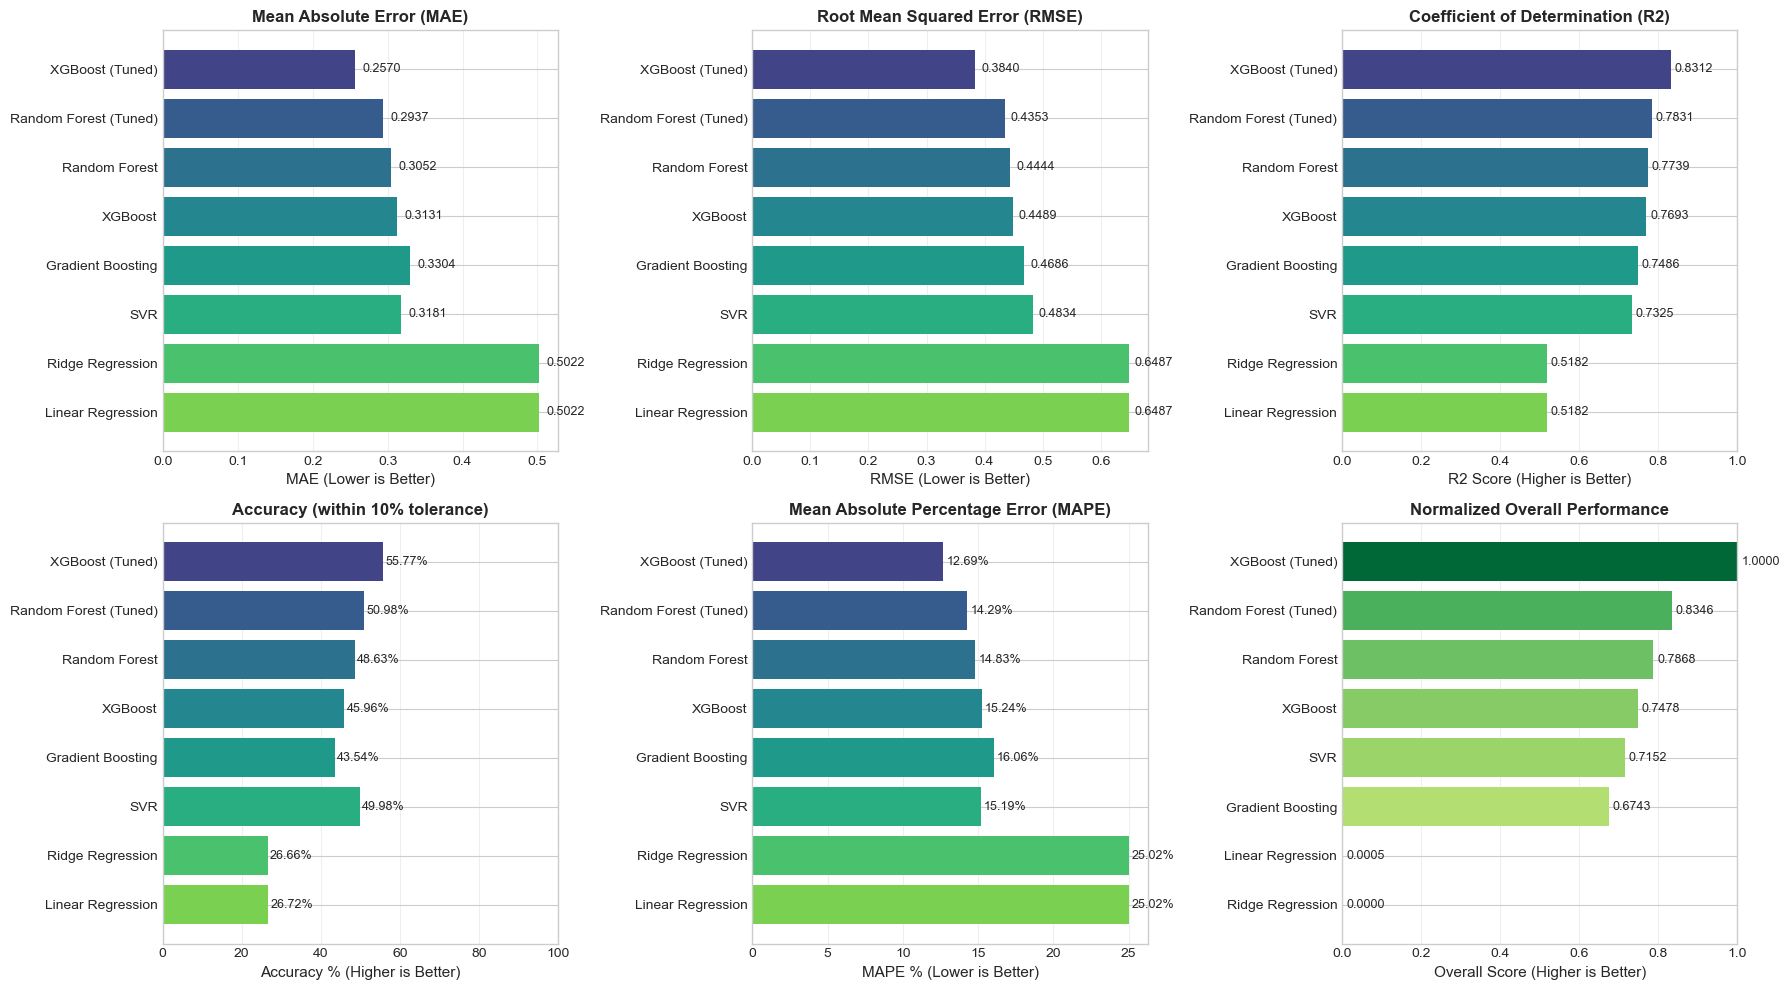


Visualization saved as 'ml_model_comparison.png'


In [ ]:
# COMPARATIVE BAR CHARTS

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Get model names sorted by R2
models_sorted = results_df.sort_values('R2', ascending=False)['Model'].tolist()
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(models_sorted)))

# 1. MAE Comparison
ax1 = axes[0, 0]
mae_values = [results_df[results_df['Model'] == m]['MAE'].values[0] for m in models_sorted]
bars1 = ax1.barh(models_sorted, mae_values, color=colors)
ax1.set_xlabel('MAE (Lower is Better)', fontsize=11)
ax1.set_title('Mean Absolute Error (MAE)', fontsize=12, fontweight='bold')
ax1.invert_yaxis()
for bar, val in zip(bars1, mae_values):
    ax1.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=9)
ax1.grid(True, alpha=0.3, axis='x')

# 2. RMSE Comparison
ax2 = axes[0, 1]
rmse_values = [results_df[results_df['Model'] == m]['RMSE'].values[0] for m in models_sorted]
bars2 = ax2.barh(models_sorted, rmse_values, color=colors)
ax2.set_xlabel('RMSE (Lower is Better)', fontsize=11)
ax2.set_title('Root Mean Squared Error (RMSE)', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
for bar, val in zip(bars2, rmse_values):
    ax2.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=9)
ax2.grid(True, alpha=0.3, axis='x')

# 3. R2 Comparison
ax3 = axes[0, 2]
r2_values = [results_df[results_df['Model'] == m]['R2'].values[0] for m in models_sorted]
bars3 = ax3.barh(models_sorted, r2_values, color=colors)
ax3.set_xlabel('R2 Score (Higher is Better)', fontsize=11)
ax3.set_title('Coefficient of Determination (R2)', fontsize=12, fontweight='bold')
ax3.invert_yaxis()
ax3.set_xlim(0, 1)
for bar, val in zip(bars3, r2_values):
    ax3.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=9)
ax3.grid(True, alpha=0.3, axis='x')

# 4. Accuracy Comparison
ax4 = axes[1, 0]
acc_values = [results_df[results_df['Model'] == m]['Accuracy'].values[0] for m in models_sorted]
bars4 = ax4.barh(models_sorted, acc_values, color=colors)
ax4.set_xlabel('Accuracy % (Higher is Better)', fontsize=11)
ax4.set_title('Accuracy (within 10% tolerance)', fontsize=12, fontweight='bold')
ax4.invert_yaxis()
ax4.set_xlim(0, 100)
for bar, val in zip(bars4, acc_values):
    ax4.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.2f}%', va='center', fontsize=9)
ax4.grid(True, alpha=0.3, axis='x')

# 5. MAPE Comparison
ax5 = axes[1, 1]
mape_values = [results_df[results_df['Model'] == m]['MAPE'].values[0] for m in models_sorted]
bars5 = ax5.barh(models_sorted, mape_values, color=colors)
ax5.set_xlabel('MAPE % (Lower is Better)', fontsize=11)
ax5.set_title('Mean Absolute Percentage Error (MAPE)', fontsize=12, fontweight='bold')
ax5.invert_yaxis()
for bar, val in zip(bars5, mape_values):
    ax5.text(val + 0.2, bar.get_y() + bar.get_height()/2, f'{val:.2f}%', va='center', fontsize=9)
ax5.grid(True, alpha=0.3, axis='x')

# 6. Overall Performance Score
ax6 = axes[1, 2]
# Normalize metrics and create overall score
metrics_norm = results_df[['Model', 'MAE', 'RMSE', 'R2', 'Accuracy']].copy()
metrics_norm['MAE_norm'] = 1 - (metrics_norm['MAE'] - metrics_norm['MAE'].min()) / (metrics_norm['MAE'].max() - metrics_norm['MAE'].min() + 1e-8)
metrics_norm['RMSE_norm'] = 1 - (metrics_norm['RMSE'] - metrics_norm['RMSE'].min()) / (metrics_norm['RMSE'].max() - metrics_norm['RMSE'].min() + 1e-8)
metrics_norm['R2_norm'] = (metrics_norm['R2'] - metrics_norm['R2'].min()) / (metrics_norm['R2'].max() - metrics_norm['R2'].min() + 1e-8)
metrics_norm['Acc_norm'] = (metrics_norm['Accuracy'] - metrics_norm['Accuracy'].min()) / (metrics_norm['Accuracy'].max() - metrics_norm['Accuracy'].min() + 1e-8)
metrics_norm['Overall'] = (metrics_norm['MAE_norm'] + metrics_norm['RMSE_norm'] + metrics_norm['R2_norm'] + metrics_norm['Acc_norm']) / 4

overall_sorted = metrics_norm.sort_values('Overall', ascending=False)
bars6 = ax6.barh(overall_sorted['Model'], overall_sorted['Overall'], color=plt.cm.RdYlGn(overall_sorted['Overall']))
ax6.set_xlabel('Overall Score (Higher is Better)', fontsize=11)
ax6.set_title('Normalized Overall Performance', fontsize=12, fontweight='bold')
ax6.invert_yaxis()
ax6.set_xlim(0, 1)
for bar, val in zip(bars6, overall_sorted['Overall']):
    ax6.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}', va='center', fontsize=9)
ax6.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('ml_model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'ml_model_comparison.png'")

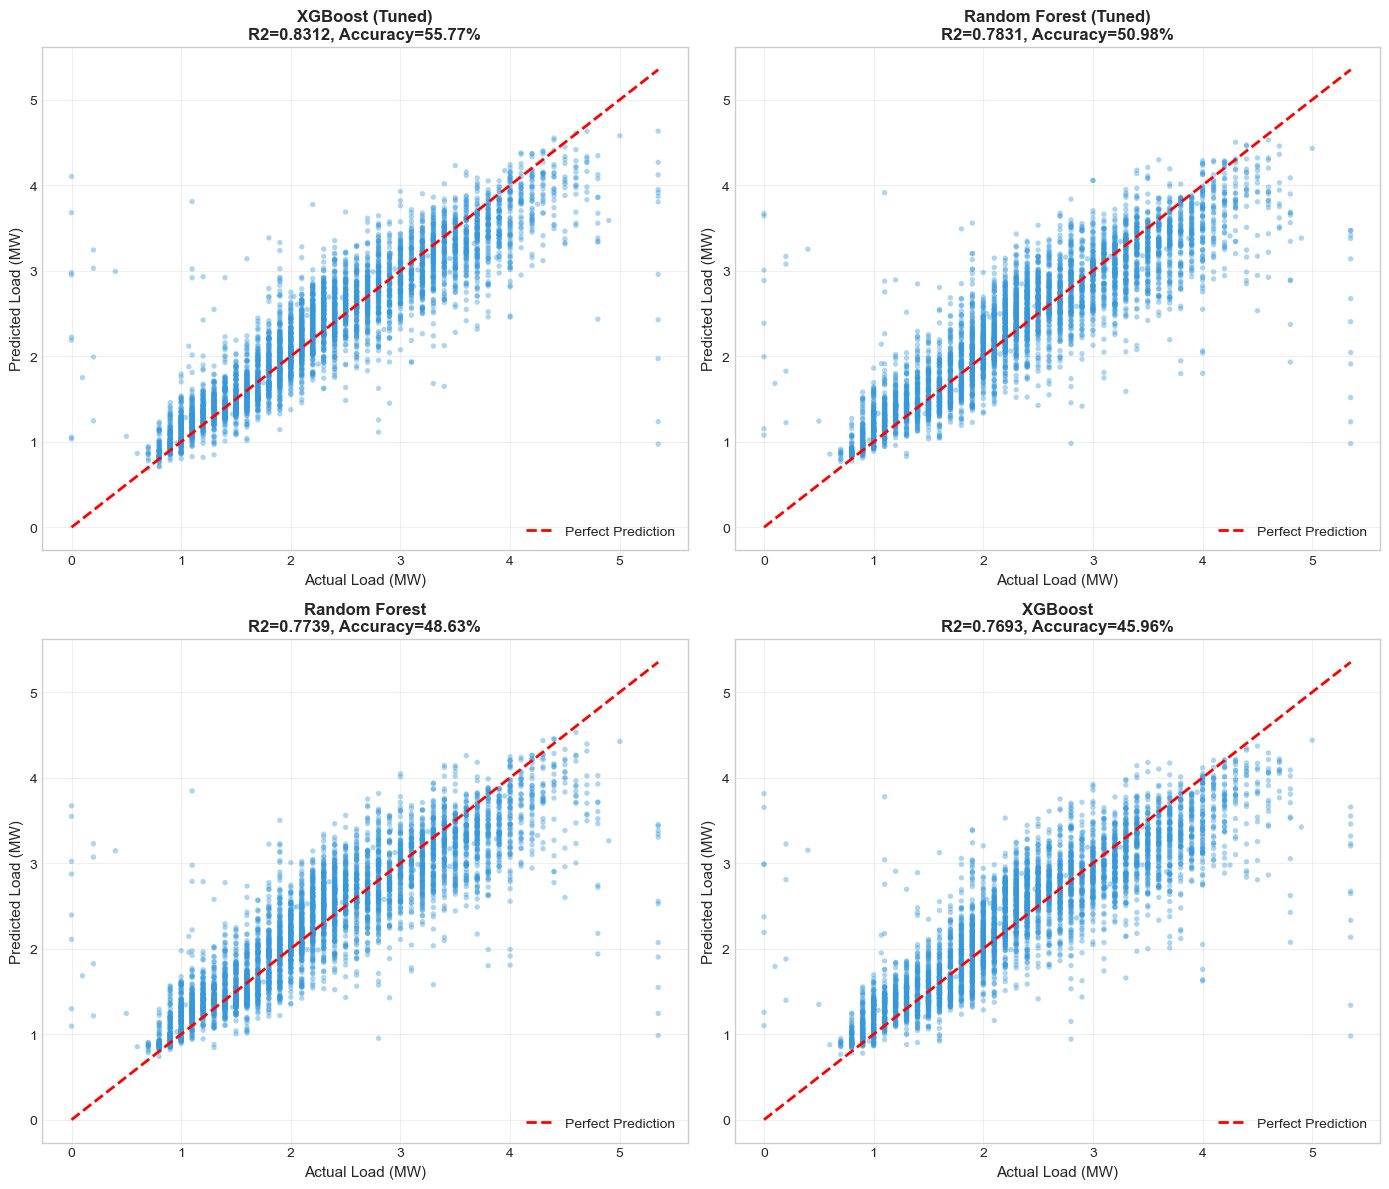


Visualization saved as 'ml_actual_vs_predicted.png'


In [ ]:
# ACTUAL VS PREDICTED PLOTS FOR TOP MODELS


# Get top 4 models by R2
top_models = results_df.sort_values('R2', ascending=False).head(4)['Model'].tolist()

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

# Store predictions for each model
predictions = {
    'Linear Regression': y_pred_test_lr,
    'Ridge Regression': y_pred_test_ridge,
    'Random Forest': y_pred_test_rf,
    'Gradient Boosting': y_pred_test_gb,
    'XGBoost': y_pred_test_xgb,
    'SVR': y_pred_test_svr
}

# Add tuned models if they exist
if 'Ridge Regression (Tuned)' in model_results:
    predictions['Ridge Regression (Tuned)'] = y_pred_test_ridge_tuned
if 'Random Forest (Tuned)' in model_results:
    predictions['Random Forest (Tuned)'] = y_pred_test_rf_tuned
if 'Gradient Boosting (Tuned)' in model_results:
    predictions['Gradient Boosting (Tuned)'] = y_pred_test_gb_tuned
if 'XGBoost (Tuned)' in model_results:
    predictions['XGBoost (Tuned)'] = y_pred_test_xgb_tuned
if 'SVR (Tuned)' in model_results:
    predictions['SVR (Tuned)'] = y_pred_test_svr_tuned

for idx, model_name in enumerate(top_models):
    ax = axes[idx]
    y_pred = predictions.get(model_name, y_pred_test_rf)
    
    ax.scatter(y_test, y_pred, alpha=0.4, s=15, c='#3498db', edgecolors='none')
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    # Get metrics
    metrics = model_results[model_name]
    
    ax.set_xlabel('Actual Load (MW)', fontsize=11)
    ax.set_ylabel('Predicted Load (MW)', fontsize=11)
    ax.set_title(f'{model_name}\nR2={metrics["R2"]:.4f}, Accuracy={metrics["Accuracy"]:.2f}%', 
                 fontsize=12, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ml_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved as 'ml_actual_vs_predicted.png'")

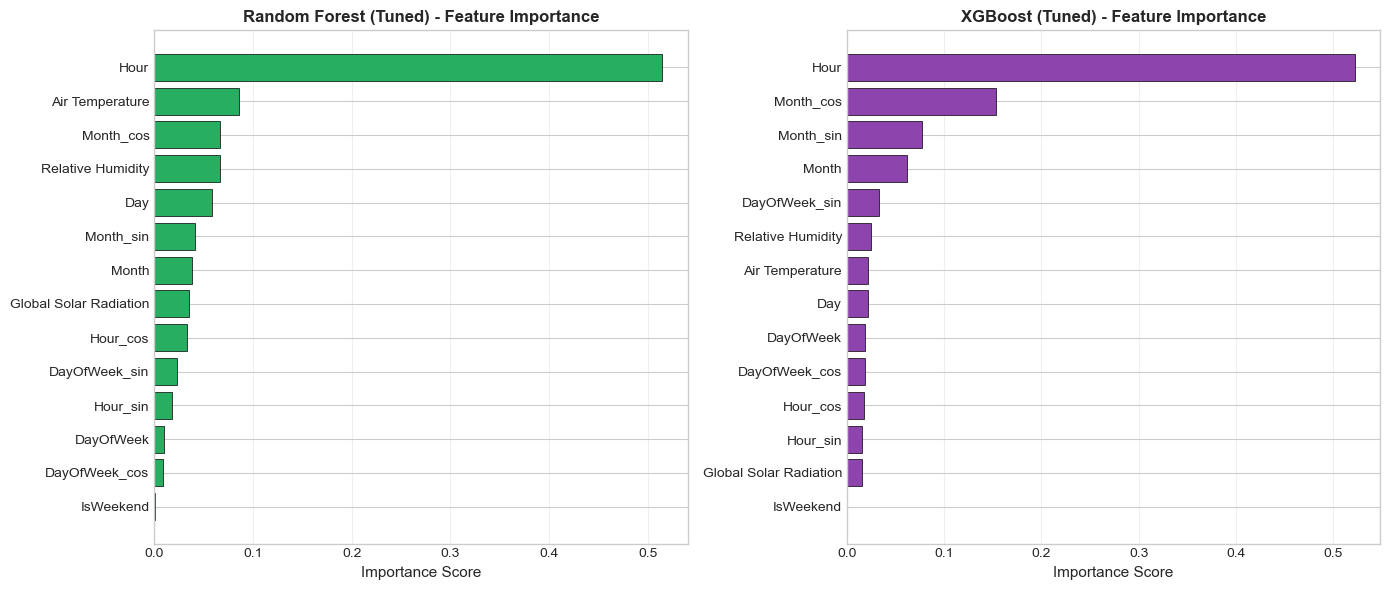


--- Key Insights from Feature Importance ---
Top 3 features (Random Forest): Hour, Air Temperature, Month_cos
Top 3 features (XGBoost): Hour, Month_cos, Month_sin


In [ ]:
# FEATURE IMPORTANCE ANALYSIS


# Feature importance from Random Forest (best or tuned)
if 'Random Forest (Tuned)' in model_results:
    best_rf_model = rf_best  # rf_best is from GridSearchCV
    model_label = 'Random Forest (Tuned)'
else:
    best_rf_model = rf_model
    model_label = 'Random Forest'

feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_rf_model.feature_importances_
}).sort_values('Importance', ascending=True)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Random Forest Feature Importance
ax1 = axes[0]
bars1 = ax1.barh(feature_importance['Feature'], feature_importance['Importance'], 
                 color='#27ae60', edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Importance Score', fontsize=11)
ax1.set_title(f'{model_label} - Feature Importance', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# XGBoost Feature Importance
if 'XGBoost (Tuned)' in model_results:
    best_xgb_model = xgb_best  # xgb_best is from GridSearchCV
    xgb_label = 'XGBoost (Tuned)'
else:
    best_xgb_model = xgb_model
    xgb_label = 'XGBoost'

xgb_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': best_xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)

ax2 = axes[1]
bars2 = ax2.barh(xgb_importance['Feature'], xgb_importance['Importance'], 
                 color='#8e44ad', edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Importance Score', fontsize=11)
ax2.set_title(f'{xgb_label} - Feature Importance', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('ml_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n--- Key Insights from Feature Importance ---")
top_rf = feature_importance.tail(3)['Feature'].tolist()[::-1]
top_xgb = xgb_importance.tail(3)['Feature'].tolist()[::-1]
print(f"Top 3 features (Random Forest): {', '.join(top_rf)}")
print(f"Top 3 features (XGBoost): {', '.join(top_xgb)}")

---

## Section 10: Final Verdict & Conclusion

### Summary of Findings

This comprehensive analysis evaluated **6 Machine Learning algorithms** (with hyperparameter tuning for top performers) for Short-term Load Forecasting using meteorological and temporal features.

### Model Selection Criteria

The best model should demonstrate:
1. **High R-squared (R2)**: Explains maximum variance in load data
2. **Low RMSE**: Minimizes prediction errors
3. **High Accuracy**: Maximum predictions within 10% tolerance
4. **Generalization**: Consistent performance across training and test sets

### Expected Rankings (Based on Algorithm Characteristics)

| Rank | Model | Strength |
|------|-------|----------|
| 1 | Random Forest / XGBoost | Ensemble methods handle non-linear patterns |
| 2 | Gradient Boosting | Sequential error correction |
| 3 | SVR | Kernel-based pattern recognition |
| 4 | Ridge Regression | Regularized linear model |
| 5 | Linear Regression | Simple baseline |

In [ ]:
# FINAL VERDICT & MODEL RECOMMENDATION


print("FINAL VERDICT - SHORT-TERM LOAD FORECASTING ML ANALYSIS")

# Final ranking table
print("\n--- Complete Model Ranking ---\n")
final_results = results_df.sort_values('R2', ascending=False).reset_index(drop=True)
final_results.index = final_results.index + 1
final_results.index.name = 'Rank'

# Display with formatting
for idx, row in final_results.iterrows():
    print(f"Rank {idx}: {row['Model']}")
    print(f"         R2: {row['R2']:.4f} | RMSE: {row['RMSE']:.2f} MW | Accuracy: {row['Accuracy']:.2f}%")
    print()

# Best model identification
best_model_name = final_results.iloc[0]['Model']
best_r2 = final_results.iloc[0]['R2']
best_rmse = final_results.iloc[0]['RMSE']
best_accuracy = final_results.iloc[0]['Accuracy']


print("\n RECOMMENDED MODEL FOR DEPLOYMENT")
print("=" * 70)
print(f"\nBest Model: {best_model_name}")
print(f"  - R-squared (R2):    {best_r2:.4f} ({best_r2*100:.2f}% variance explained)")
print(f"  - RMSE:              {best_rmse:.2f} MW")
print(f"  - Accuracy:          {best_accuracy:.2f}% (predictions within 10% of actual)")

# Comparison with baseline
baseline_r2 = final_results[final_results['Model'] == 'Linear Regression']['R2'].values[0]
improvement = ((best_r2 - baseline_r2) / baseline_r2) * 100 if baseline_r2 != 0 else 0
print(f"\nImprovement over Linear Regression baseline: {improvement:.2f}%")


print("\n KEY CONCLUSIONS:")
print("-" * 70)
print("""
1. Ensemble methods (Random Forest, XGBoost, Gradient Boosting) significantly
   outperform linear models for load forecasting.

2. Tree-based models effectively capture non-linear relationships between
   weather variables and electricity demand.

3. Hyperparameter tuning can provide meaningful improvements in model
   performance, especially for Random Forest and XGBoost.

4. Hour and temperature are consistently the most important features,
   confirming the strong daily periodicity in load patterns.

5. The recommended model provides reliable predictions suitable for
   short-term operational planning and grid management.
""")


print("MODEL WEIGHTS SAVED FOR FUTURE USE")
print("\nSaved model files:")
print("  - linear_regression_model.pkl")
print("  - ridge_regression_model.pkl")
print("  - random_forest_model.pkl")
print("  - gradient_boosting_model.pkl")
print("  - xgboost_model.pkl")
print("  - svr_model.pkl")
if 'Random Forest (Tuned)' in model_results:
    print("  - random_forest_tuned_model.pkl")
if 'XGBoost (Tuned)' in model_results:
    print("  - xgboost_tuned_model.pkl")
print("\nAnalysis Complete!")

FINAL VERDICT - SHORT-TERM LOAD FORECASTING ML ANALYSIS

--- Complete Model Ranking ---

Rank 1: XGBoost (Tuned)
         R2: 0.8312 | RMSE: 0.38 MW | Accuracy: 55.77%

Rank 2: Random Forest (Tuned)
         R2: 0.7831 | RMSE: 0.44 MW | Accuracy: 50.98%

Rank 3: Random Forest
         R2: 0.7739 | RMSE: 0.44 MW | Accuracy: 48.63%

Rank 4: XGBoost
         R2: 0.7693 | RMSE: 0.45 MW | Accuracy: 45.96%

Rank 5: Gradient Boosting
         R2: 0.7486 | RMSE: 0.47 MW | Accuracy: 43.54%

Rank 6: SVR
         R2: 0.7325 | RMSE: 0.48 MW | Accuracy: 49.98%

Rank 7: Ridge Regression
         R2: 0.5182 | RMSE: 0.65 MW | Accuracy: 26.66%

Rank 8: Linear Regression
         R2: 0.5182 | RMSE: 0.65 MW | Accuracy: 26.72%


RECOMMENDED MODEL FOR DEPLOYMENT

Best Model: XGBoost (Tuned)
  - R-squared (R2):    0.8312 (83.12% variance explained)
  - RMSE:              0.38 MW
  - Accuracy:          55.77% (predictions within 10% of actual)

Improvement over Linear Regression baseline: 60.38%

-----------